In [ ]:
# Data taken from Boston Housing Dataset available on Kaggle. https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data

# Exploration of a couple of different methods of predicting median house price in a Boston neighborhood from various neighborhood information. 
# Uses Linear Regression, LR + Ridge Regularization, Random Forest and XGBoost models. 

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, RidgeCV
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor

In [35]:
# Load the Boston Housing Dataset
df = pd.read_csv("C:/Users/Conor/Documents/Personal_projects_data/boston.csv")

In [11]:
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Early Data Cleaning:

In [12]:
# How clean is the data? Are there missing values?
missing = df.isnull().sum()[df.isnull().sum() > 0]
if missing.empty:
    print("No missing data! Yay!")

df.info()

No missing data! Yay!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [13]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Exploratory Analysis:

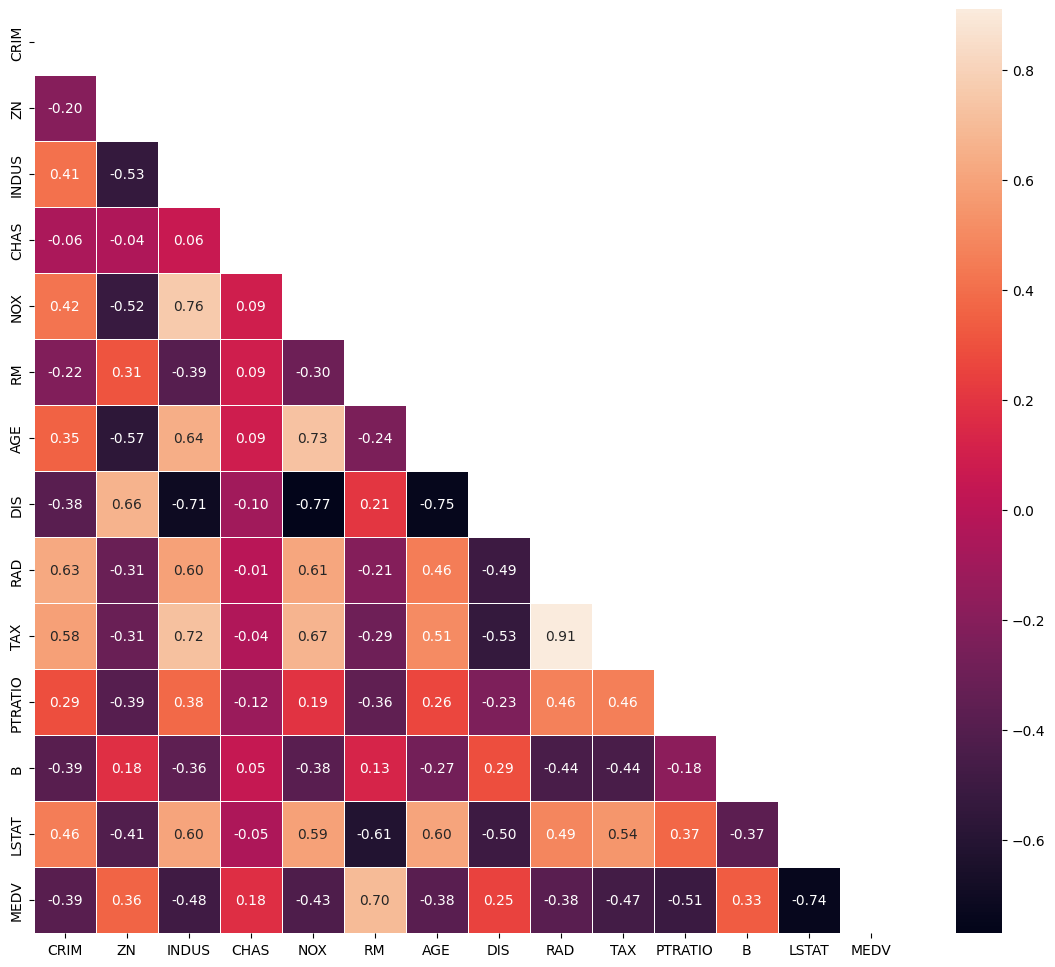

In [14]:
#heatmap show co-relations numeric columns
f,ax = plt.subplots(figsize=(14,12))
numeric_df = df.select_dtypes(include=['number'])
matrix = numeric_df.corr()
mask = np.triu(np.ones_like(matrix, dtype=bool))
sns.heatmap(matrix, annot=True, linewidths=.5, fmt= '.2f',ax=ax,mask=mask)
plt.show()

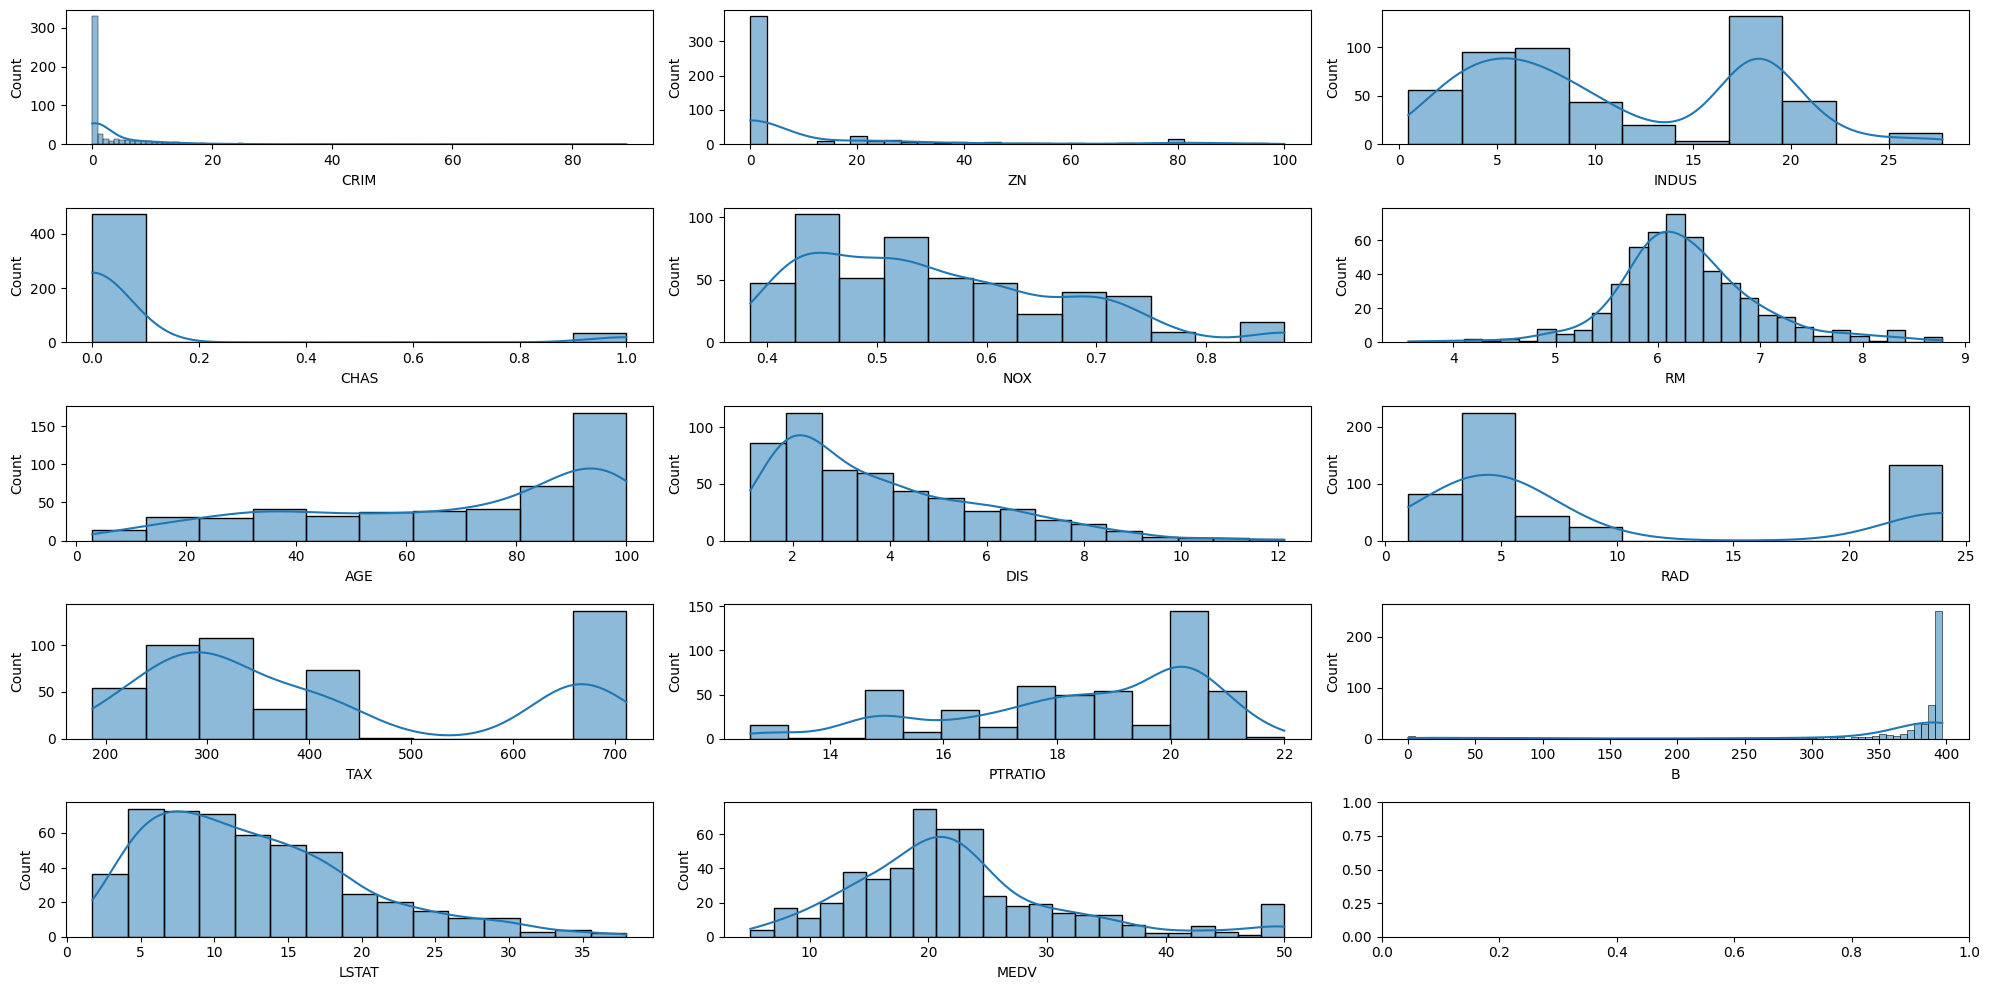

In [15]:
num_atts = df.select_dtypes(exclude=['object']).columns # numeric attributes' data type are not object

fig, axes = plt.subplots(int(np.ceil(len(num_atts)/3)), 3, figsize = (20, 10))
for i, att in zip(range(len(num_atts)), num_atts):
    sns.histplot(ax = axes[int(np.floor(i/3))][i%3], 
                x = att, data = df,kde=True)
    
plt.tight_layout()

Some data are clearly very skewed, will need to be corrected.

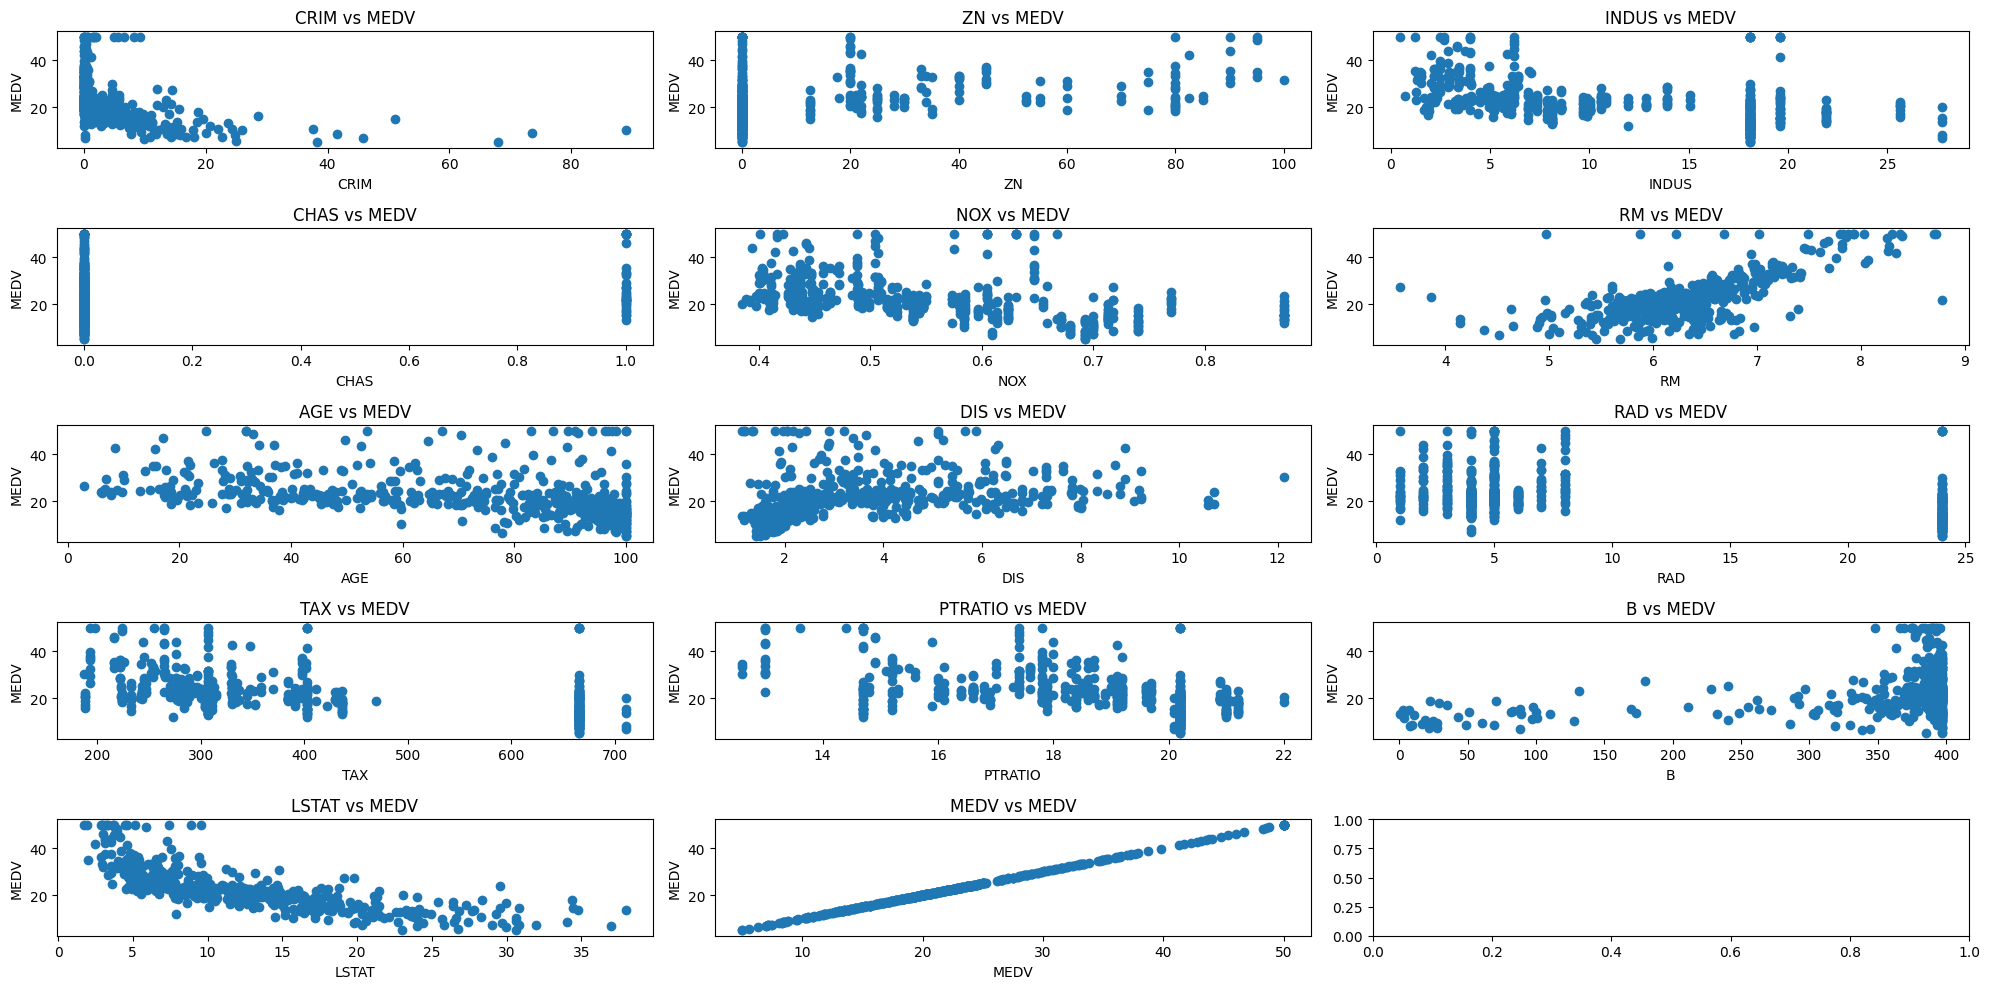

In [16]:
num_atts = df.select_dtypes(exclude=['object']).columns  # Numeric attributes
y = df.MEDV  # Response variable
fig, axes = plt.subplots(int(np.ceil(len(num_atts)/3)), 3, figsize=(20, 10))

# Flatten axes to make indexing easier
axes = axes.flatten()

for i, att in enumerate(num_atts):
    axes[i].scatter(df[att], y)  # Scatter plot for each feature
    axes[i].set_xlabel(att)  # Set x-axis label
    axes[i].set_ylabel('MEDV')  # Set y-axis label
    axes[i].set_title(f'{att} vs MEDV')  # Set title

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [17]:
# Using Variance Inflation Factor, check for multicolinearity: 
X = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]

vif = pd.DataFrame()
vif['features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i ) for i in range(X.shape[1])]
vif

,features,VIF
0,CRIM,2.100373
1,ZN,2.844013
2,INDUS,14.485758
3,CHAS,1.152952
4,NOX,73.894947
5,RM,77.948283
6,AGE,21.386850
7,DIS,14.699652
8,RAD,15.167725
9,TAX,61.227274


In [18]:
# Using Variance Inflation Factor, check for multicolinearity: 
X2 = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'DIS', 'RAD', 'LSTAT']]

vif = pd.DataFrame()
vif['features'] = X2.columns
vif['VIF'] = [variance_inflation_factor(X2.values, i ) for i in range(X2.shape[1])]
vif

df_cleaned = df[X2.columns.tolist()]

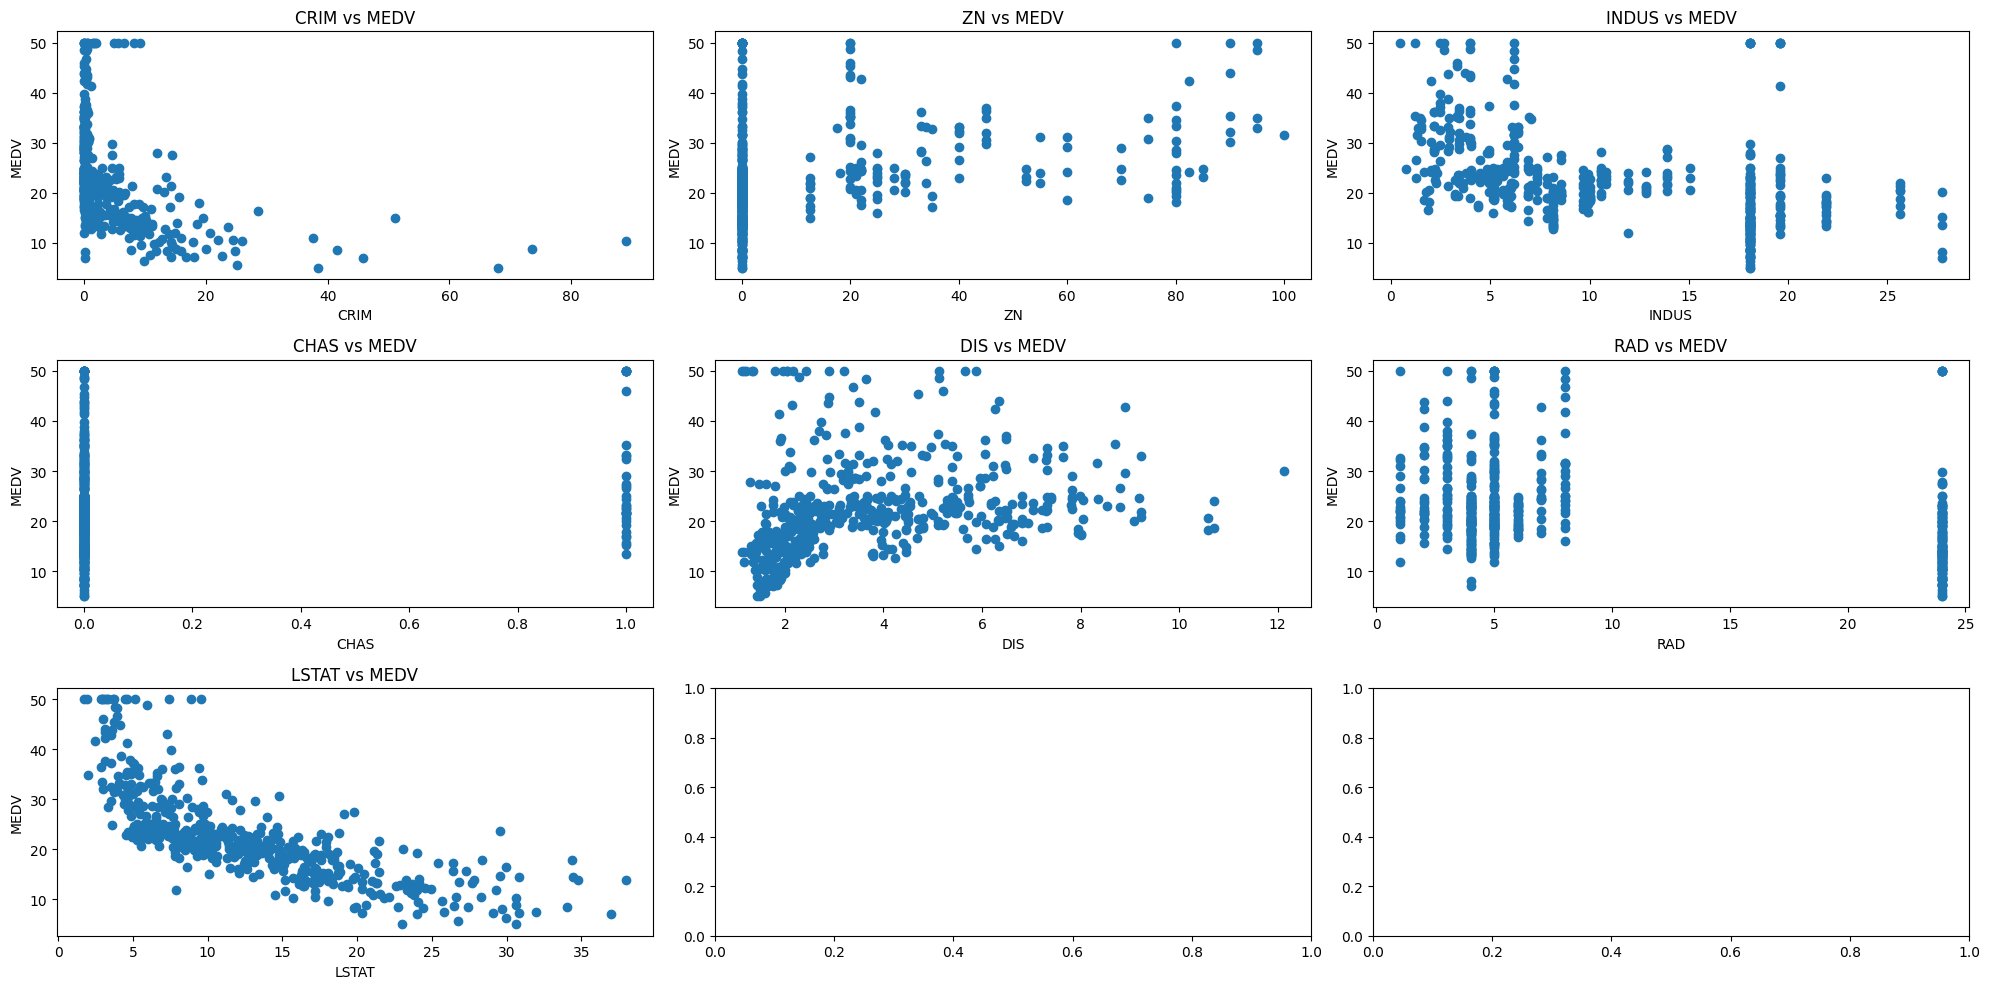

In [19]:
num_atts = df_cleaned.select_dtypes(exclude=['object']).columns  # Numeric attributes
y = df.MEDV  # Response variable
fig, axes = plt.subplots(int(np.ceil(len(num_atts)/3)), 3, figsize=(20, 10))

# Flatten axes to make indexing easier
axes = axes.flatten()

for i, att in enumerate(num_atts):
    axes[i].scatter(df_cleaned[att], y)  # Scatter plot for each feature
    axes[i].set_xlabel(att)  # Set x-axis label
    axes[i].set_ylabel('MEDV')  # Set y-axis label
    axes[i].set_title(f'{att} vs MEDV')  # Set title

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [20]:
skewness = df_cleaned.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(skewness)
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_cleaned[skewed_features] = np.log1p(df_cleaned[skewed_features])

CRIM     5.207652
ZN       2.219063
CHAS     3.395799
DIS      1.008779
RAD      1.001833
LSTAT    0.903771
dtype: float64
6 skewed numerical features to log transform


C:\Users\Conor\AppData\Local\Temp\ipykernel_8128\2819480479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[skewed_features] = np.log1p(df_cleaned[skewed_features])


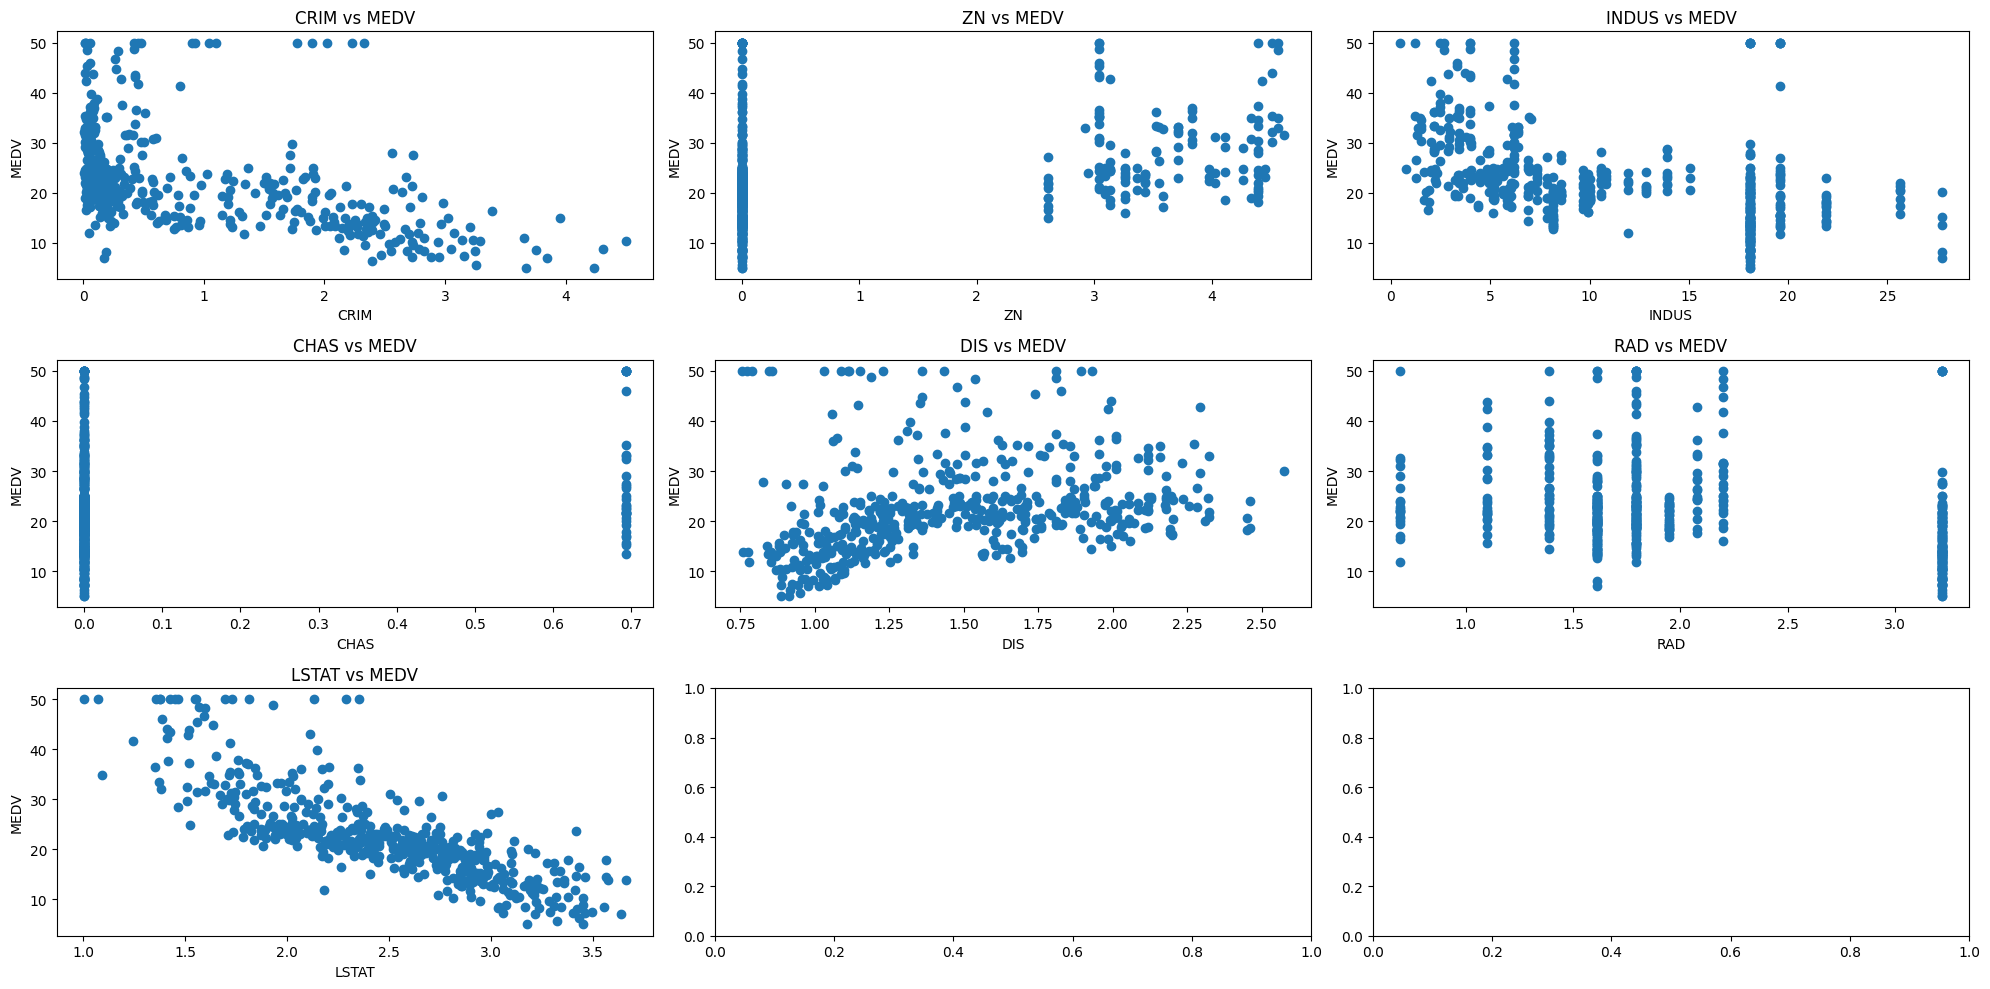

In [21]:
num_atts = df_cleaned.select_dtypes(exclude=['object']).columns  # Numeric attributes
y = df.MEDV  # Response variable
fig, axes = plt.subplots(int(np.ceil(len(num_atts)/3)), 3, figsize=(20, 10))

# Flatten axes to make indexing easier
axes = axes.flatten()

for i, att in enumerate(num_atts):
    axes[i].scatter(df_cleaned[att], y)  # Scatter plot for each feature
    axes[i].set_xlabel(att)  # Set x-axis label
    axes[i].set_ylabel('MEDV')  # Set y-axis label
    axes[i].set_title(f'{att} vs MEDV')  # Set title

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned, y, test_size = 0.3, random_state = 0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(354, 7)
(152, 7)
(354,)
(152,)


In [23]:
# Standardize all numerical features: This can only be done after the train-test split as we don't want to standard scale some features that will be used in test observations. 

# Standardize numerical features
stdSc = StandardScaler()
X_train = stdSc.fit_transform(X_train)
X_test = stdSc.transform(X_test)

In [24]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

RMSE on Training set : 4.7422330951175296
RMSE on Test set : 5.135052217953247
Train R2 value 0.750732280744564
Test R2 value 0.6723670941673401


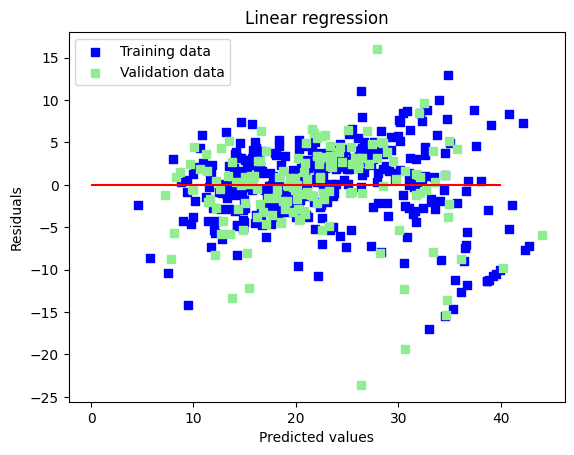

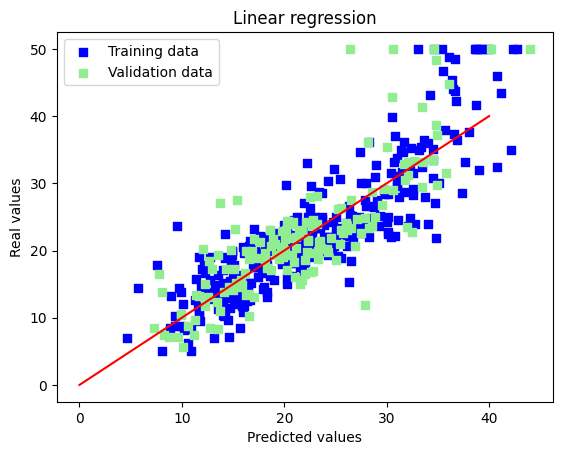

In [25]:
lr = LinearRegression()
lr.fit(X_train,y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

r2_train = lr.score(X_train, y_train)
print("Train R2 value " + str(r2_train))

r2 = lr.score(X_test, y_test)
print("Test R2 value " + str(r2))

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 40, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 40], [0, 40], c = "red")
plt.show()

<Axes: xlabel='MEDV'>

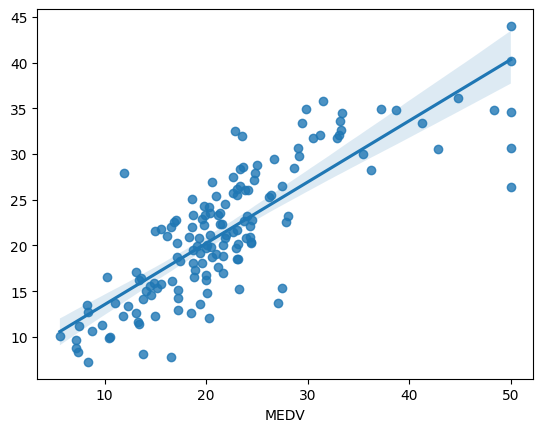

In [26]:
sns.regplot(x=y_test,y=y_test_pred)

IMPROVING PREDICTION WITH REGULARIZATION 1: RIDGE REGULARIZATION

In [27]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)

ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

train_r2 = ridge.score(X_train, y_train)  # R² on training data
test_r2 = ridge.score(X_test, y_test)  # R² on test data

print("Train R²:", train_r2)
print("Test R²:", test_r2)

Best alpha : 3.0
Try again for more precision with alphas centered around 3.0
Best alpha : 4.199999999999999
Ridge RMSE on Training set : 4.736227705395302
Ridge RMSE on Test set : 5.118141242262721
Train R²: 0.7504697863146367
Test R²: 0.6719379232822944


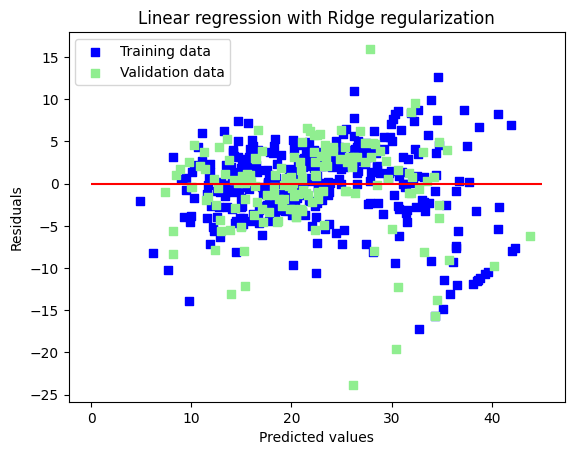

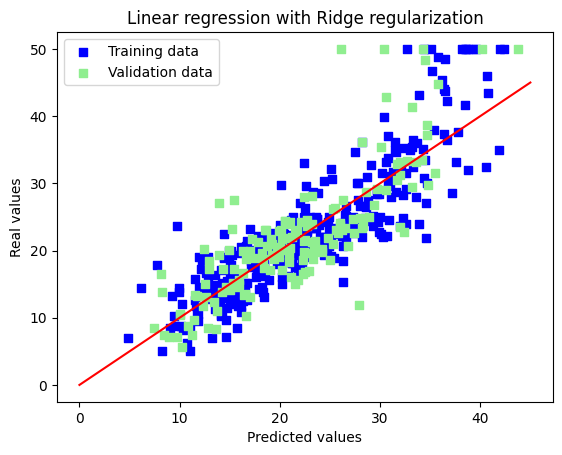

In [28]:
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 0, xmax = 45, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 45], [0, 45], c = "red")
plt.show()

It looks like ridge regularization doesn't make much difference to the predictive ability of the model. 

Random Forest Regression:

In [29]:
# Using the sklearn random forest regressor.

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 50, random_state = 0, max_depth=10)
RandomForest_reg.fit(X_train, y_train)

# Model making a prediction on test data
y_pred = RandomForest_reg.predict(X_test)

r2_train = RandomForest_reg.score(X_train, y_train)
r2_test = RandomForest_reg.score(X_test, y_test)
RMSE = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
print("Train R2: " + str(r2_train))
print("Test R2: " + str(r2_test))
print("RMSE: " + str(RMSE))
print("Feature importances:" + str(RandomForest_reg.feature_importances_))
print(df_cleaned.columns)

Train R2: 0.9717050353253875
Test R2: 0.7007725727260599
RMSE: 4.991525001222436
Feature importances:[0.06363794 0.01125324 0.06873175 0.00350233 0.10348078 0.00966376
 0.73973021]
Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'DIS', 'RAD', 'LSTAT'], dtype='object')


Random forest seems to overfit quite badly.  Test R2 no better than with linear regression.

TRY RANDOM FOREST WITHOUT DROPPING FEATURES:

In [36]:
# Remove target variable:
df.drop(['MEDV'],axis=1,inplace=True)

# # Identify skewed features and correct with log transform. 
# skewness = df.apply(lambda x: skew(x))
# skewness = skewness[abs(skewness) > 0.5]
# print(skewness)
# print(str(skewness.shape[0]) + " skewed numerical features to log transform")
# skewed_features = skewness.index
# df[skewed_features] = np.log1p(df[skewed_features])

In [37]:
# Split data into test and train sets:
X2_train, X2_test, y2_train, y2_test = train_test_split(df, y, test_size = 0.3, random_state = 0)
print(X2_train.shape)
print(X2_test.shape)
print(y2_train.shape)
print(y2_test.shape)

(354, 13)
(152, 13)
(354,)
(152,)


In [38]:
# Standard Scale data before modelling: 
stdSc = StandardScaler()
X2_train = stdSc.fit_transform(X2_train)
X2_test = stdSc.transform(X2_test)

In [46]:
# Using the sklearn random forest regressor.

cv_rf = cross_val_score(estimator = RandomForest_reg, X = X2_train, y = y2_train, cv = 10)

# Creating and training model
RandomForest_reg = RandomForestRegressor(n_estimators = 100, random_state = 0)
RandomForest_reg.fit(X2_train, y2_train)

# Model making a prediction on test data
y2_pred = RandomForest_reg.predict(X2_test)

r2_2_train = RandomForest_reg.score(X2_train, y2_train)
r2_2_test = RandomForest_reg.score(X2_test, y2_test)
RMSE2 = np.sqrt(metrics.mean_squared_error(y2_test,y2_pred))
print("Train R2: " + str(r2_2_train))
print("Test R2: " + str(r2_2_test))
print("RMSE: " + str(RMSE2))
print("Cross Validated R2: ", round( cv_rf.mean(),4) )

Train R2: 0.9839372710891255
Test R2: 0.8258535659503106
RMSE: 3.8079377871479827
Cross Validated R2:  0.8166


TRY IT WITH XGBOOST, BETTER PERFORMANCE?

In [73]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.25,max_depth=25,alpha=2)
model.fit(X2_train, y2_train)
y2_pred = model.predict(X2_test)
r2_train = model.score(X2_train, y2_train)
r2_test = model.score(X2_test, y2_test)
print("R2 Train:" + str(r2_train))
print("R2 Test:" + str(r2_test))

cv_scores = cross_val_score(model, X2_train, y2_train, cv=10)
print("Cross-Validation Scores: ", np.mean(cv_scores))

R2 Train:0.9994613135085034
R2 Test:0.8295400387747854
Cross-Validation Scores:  0.8215945073352751


XGBoost performs roughly the same as random forest. 